In [1]:
from data.SLP_RD import SLP_RD
from data.SLP_FD import SLP_FD
import utils.vis as vis
import utils.utils as ut
from utils.utils_ds import *
import numpy as np
import opt
import cv2
import torch
import json
from os import path
import os
from utils.logger import Colorlogger
from utils.utils_tch import get_model_summary
from core.loss import JointsMSELoss
from torch.utils.data import DataLoader
from torch.optim import Adam
import time
from utils.utils_ds import accuracy, flip_back
from utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from skimage import io, color
import torchvision.transforms as transforms
import configargparse
from model.HRpose import get_pose_net

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
CHECKPOINT_DIR = "checkpoints/"
checkpoints_folders = [path.join(CHECKPOINT_DIR, f, 'model_dump') for f in os.listdir(CHECKPOINT_DIR)]
CHECKPOINTS = [path.join(f, os.listdir(f)[0]) for f in checkpoints_folders]
IMAGE_PATH = "data/KISS/images/frame_00119.jpg"
SAMPLE_IMAGE = "data/SLP/danaLab/00013/RGB/cover1/image_000001.png"
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# -- env settings
ds_fd = '/tf/02_code/SLP-Dataset-and-Code/data'  # dataset directory
output_dir = '/tf/02_code/SLP-Dataset-and-Code/checkpoints'  # output directory
modelConf = 'config/HRpose.conf'  # config file path
ifb_debug = False
suffix_ptn_train = '{model}'
suffix_exp_train = 'ts1'
suffix_ptn_test = '{testset}-{SLP_set}'
suffix_exp_test = 'exp'

# -- data setting
prep = 'SLP_A2J'
SLP_set = 'danaLab'
mod_src = ['RGB']  # source modality list
cov_li = ['uncover', 'cover1', 'cover2']  # cover conditions
fc_depth = 50.0  # depth factor
if_bb = False  # use bounding box

# -- model settings
model = 'HRpose'
n_layers_D = 3
net_BB = 'res50'  # backbone network
out_shp = (64, 64, -1)  # output shape

# -- train settings
trainset = ['SLP']  # main dataset
sz_pch = (256, 256)  # input image size
end_epoch = 100
epoch_step = -1
trainIter = -1
optimizer = 'adam'
lr = 1e-3
lr_policy = 'multi_step'
lr_dec_epoch = [70, 90]
lr_dec_factor = 0.1
batch_size_pGPU = 60
gpu_ids = [0]
start_epoch = -1
init_type = 'xavier'
n_thread = 10
save_step = 1
if_pinMem = False
if_finalTest = 'n'

# -- visualization
display_id = -1
display_server = "http://localhost"
display_env = 'main'
display_port = 8097
use_html = False
display_winsize = 256
display_ncols = 3
update_html_freq = 10
print_freq = 10
no_html = False

# -- test settings
if_test = False
testset = 'SLP'
testIter = -1
yn_flipTest = 'y'
if_gtRtTest = 'y'
if_adj = 'y'
testImg = None
bone_type = 'A2J'
if_loadPreds = 'n'
if_test_ckpt = 'n'
svVis_step = 1
test_par = 'test'

sizes={
    'RGB': [576, 1024],
    'PM': [84, 192],
    'IR': [120, 160],
    'depth': [424, 512]
}
means={
    'RGB': [0.3875689, 0.39156103, 0.37614644],
    'depth': [0.7302197],
    'depthRaw': [2190.869],
    'IR': [0.1924838],
    'PM': [0.009072126],
}
stds = {
    'RGB': [0.21462509, 0.22602762, 0.21271782],
    'depth': [0.25182092],
    'depthRaw': [756.1536],
    'IR': [0.077975444],
    'PM': [0.038837425],
}

In [21]:
def load_model(checkpoint_path):
	model = get_pose_net(in_ch=3, out_ch=14).cuda()
	checkpoint = torch.load(checkpoint_path)
	model.load_state_dict(checkpoint['state_dict'])
	model.eval()
	print(f"=> Loaded trained model from {checkpoint_path}")
	return model

def preprocess_image_for_inference(img_path, means, stds, input_shape=(256, 256), mod='RGB'):
    img = io.imread(img_path)
    if img.ndim == 3:
        if mod == 'IR':
            img = color.rgb2gray(img) # (H, W, 3) → (H, W)
            img = img[...,None] # (H, W) → (H, W, 1)
    
    img_height, img_width = img.shape[:2]
    
    bb = [0, 0, img_width, img_height]

    scale, rot, do_flip, do_occlusion = 1.0, 0.0, False, False
    img_patch, trans = generate_patch_image(img, bb, do_flip, scale, rot, do_occlusion, input_shape=input_shape)

    if img_patch.ndim < 3:
        img_patch = np.expand_dims(img_patch, axis=-1)  # (H, W) → (H, W, 1)
        
    for i in range(img_patch.shape[2]):
        img_patch[:, :, i] = np.clip(img_patch[:, :, i], 0, 255)

    img_patch = img_patch.astype(np.float32)  # float 변환
    
    trans_tch = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=means[mod], std=stds[mod])])
    pch_tch = trans_tch(img_patch)
    pch_tch = pch_tch.unsqueeze(0)
    pch_tch = pch_tch.cuda()

    # img_patch /= 255.0  # 0~1 범위로 스케일링
    # img_patch -= mean  # 평균 빼기
    # img_patch /= std  # 표준편차로 나누기

    # img_patch = np.transpose(img_patch, (2, 0, 1))  # (H, W, C) → (C, H, W)
    # img_patch = torch.from_numpy(img_patch).float().cuda()
    # img_patch = img_patch.unsqueeze(0)  # (C, H, W) → (1, C, H, W)
    return pch_tch

def extract_joints_from_heatmap(heatmap, img_size=(256, 256), out_size=(64, 64)):
	"""
	heatmap: (1, 14, 64, 64) 형태라고 가정
	"""
	# (14, 64, 64) 형태로 변환
	heatmap_np = heatmap.detach().cpu().numpy()
	keypoints = []

	for i in range(heatmap_np.shape[0]):  # 관절 14개
		
		hm = heatmap_np[i]
		# 최대값 위치 찾기
		y, x = np.unravel_index(np.argmax(hm), hm.shape)
		# 히트맵 좌표를 원본 이미지 좌표로 비례 변환
		scale_x = img_size[1] / out_size[1]
		scale_y = img_size[0] / out_size[0]
		x_img = np.clip(int(x * scale_x), 0, img_size[1] - 1)
		y_img = np.clip(int(y * scale_y), 0, img_size[0] - 1)
		keypoints.append((x_img, y_img))

	return np.array(keypoints)

# 바운딩 박스 계산
def get_bounding_box(keypoints):
	x_min = np.min(keypoints[:, 0])
	x_max = np.max(keypoints[:, 0])
	y_min = np.min(keypoints[:, 1])
	y_max = np.max(keypoints[:, 1])
	return (x_min, y_min, x_max, y_max)

# 스켈레톤 및 바운딩 박스 시각화 함수
def visualize_pose_skeleton(image_path, keypoints, skeleton_connections, bbox, save_path):
	"""
	image_path: 원본 이미지 경로
	keypoints: (17, 2) 형태의 (x, y) 관절 좌표
	skeleton_connections: [(j1, j2), ...] 형태
	bbox: (x_min, y_min, x_max, y_max)
	"""
	img = cv2.imread(image_path)
	if img is None:
		raise ValueError(f"Image not found: {image_path}")

	for (x, y) in keypoints:
		cv2.circle(img, (x, y), 4, (0, 0, 255), -1)  # 빨간 점

	for (j1, j2) in skeleton_connections:
		x1, y1 = keypoints[j1]
		x2, y2 = keypoints[j2]
		cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 파란 선

	(x_min, y_min, x_max, y_max) = bbox
	cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # 녹색 박스

	cv2.imwrite(save_path, img)
	print(f"Saved result to {save_path}")

	plt.figure(figsize=(8, 6))
	plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
	plt.axis('off')
	plt.show()

In [19]:
def get_max_preds_single(heatmap):
    '''
    get predictions from a single score map
    heatmap: numpy.ndarray([num_joints, height, width])
    :return preds [n_jt x 2]
    '''
    assert isinstance(heatmap, np.ndarray), 'heatmap should be numpy.ndarray'
    assert heatmap.ndim == 3, 'heatmap should be 3-ndim'

    num_joints = heatmap.shape[0]
    width = heatmap.shape[2]
    heatmap_reshaped = heatmap.reshape((num_joints, -1))
    idx = np.argmax(heatmap_reshaped, 1)
    maxvals = np.amax(heatmap_reshaped, 1)  # amax, array max

    maxvals = maxvals.reshape((num_joints, 1))
    idx = idx.reshape((num_joints, 1))

    preds = np.tile(idx, (1, 2)).astype(np.float32)

    preds[:, 0] = (preds[:, 0]) % width
    preds[:, 1] = np.floor((preds[:, 1]) / width)


    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 2))
    pred_mask = pred_mask.astype(np.float32)  # clean up if too low confidence (maxvals)

    preds *= pred_mask
    return preds, maxvals

In [6]:
def visualize_pose_skeleton_on_original(image_path, keypoints, bbox, preproc_size, save_path):
	"""
	원본 이미지에 대해 전처리된 이미지 크기 기준으로 계산된 keypoints와 bbox를 변환하여 시각화하는 함수.
	
	Parameters:
		image_path (str): 원본 이미지 파일 경로.
		keypoints (np.array): 전처리된 이미지 크기에서 계산된 관절 좌표, shape: (N, 2).
		bbox (tuple): 전처리된 이미지 기준 바운딩 박스 (x_min, y_min, x_max, y_max).
		preproc_size (tuple): 전처리 이미지 크기 (height, width). 예: (256, 256).
		skels_idx (list): 관절 연결 인덱스 리스트 (예: `SLP_rd_test.skels_idx`).
		save_path (str): 결과 이미지를 저장할 경로.
	"""
	skeleton_connections = (
		(12, 13),  # Thorax → Head
		(12, 8), (8, 7), (7, 6),  # Thorax → R_Shoulder → R_Elbow → R_Wrist
		(12, 9), (9, 10), (10, 11),  # Thorax → L_Shoulder → L_Elbow → L_Wrist
		(2, 1), (1, 0),  # R_Hip → R_Knee → R_Ankle
		(3, 4), (4, 5)  # L_Hip → L_Knee → L_Ankle
	)
	img_orig = cv2.imread(image_path)
	if img_orig is None:
		raise ValueError(f"Image not found: {image_path}")
	img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

	orig_h, orig_w = img_orig.shape[:2]
	proc_h, proc_w = preproc_size

	# ✅ 스케일 변환 적용 (원본 이미지 대비 전처리 이미지의 비율)
	scale_x, scale_y = orig_w / proc_w, orig_h / proc_h

	# ✅ keypoints 좌표 변환
	keypoints_trans = keypoints * np.array([scale_x, scale_y])
	keypoints_trans = keypoints_trans.astype(int)

	# ✅ 바운딩 박스 좌표 변환
	x_min, y_min, x_max, y_max = bbox
	bbox_trans = (
		int(x_min * scale_x), int(y_min * scale_y),
		int(x_max * scale_x), int(y_max * scale_y)
	)

	# ✅ 원본 이미지에 keypoints 및 skeleton 시각화
	for x, y in keypoints_trans:
		cv2.circle(img_orig, (x, y), 4, (0, 0, 255), -1)  # 🔴 관절 점 (빨간색)

	for j1, j2 in skeleton_connections:
		x1, y1 = keypoints_trans[j1]
		x2, y2 = keypoints_trans[j2]
		cv2.line(img_orig, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 🔵 관절 연결 (파란색)

	# ✅ 변환된 바운딩 박스 그리기
	cv2.rectangle(img_orig, (bbox_trans[0], bbox_trans[1]), (bbox_trans[2], bbox_trans[3]), (0, 255, 0), 2)  # 🟢 박스

	# ✅ 결과 저장 및 시각화
	cv2.imwrite(save_path, cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR))  # OpenCV 저장은 BGR 기준
	print(f"Saved result to {save_path}")

	plt.figure(figsize=(8, 6))
	plt.imshow(img_orig)
	plt.axis('off')
	plt.show()


def visualize_pose_skeleton_from_tensor(image_tensor, keypoints, bbox, save_path):
	"""
	전처리된 이미지 텐서를 받아 시각화하는 함수.
	입력 텐서는 전처리된 이미지 크기 (예: 256x256)이며, keypoints와 bbox는 이 크기에 맞게 계산되어 있음.
	
	Parameters:
		image_tensor (torch.Tensor): 전처리된 이미지 텐서. shape: (C, H, W) 또는 (1, C, H, W).
		keypoints (np.array): 전처리 이미지 기준 관절 좌표, shape: (N, 2).
		bbox (tuple): 전처리 이미지 기준 바운딩 박스 (x_min, y_min, x_max, y_max).
		save_path (str): 결과 이미지를 저장할 경로.
	"""
	skeleton_connections = (
		(12, 13),  # Thorax → Head
		(12, 8), (8, 7), (7, 6),  # Thorax → R_Shoulder → R_Elbow → R_Wrist
		(12, 9), (9, 10), (10, 11),  # Thorax → L_Shoulder → L_Elbow → L_Wrist
		(2, 1), (1, 0),  # R_Hip → R_Knee → R_Ankle
		(3, 4), (4, 5)  # L_Hip → L_Knee → L_Ankle
	)
	
	# 텐서에서 배치 차원이 있으면 제거 후, numpy 배열로 변환
	if image_tensor.dim() == 4:
		image_tensor = image_tensor.squeeze(0)
	# image_tensor: (C, H, W) → (H, W, C)
	image_np = image_tensor.cpu().detach().numpy().transpose(1, 2, 0)
	
	# 만약 이미지가 [0, 1] 범위이면 0~255로 변환
	if image_np.max() <= 1.0:
		image_np = (image_np * 255).astype(np.uint8)
	else:
		image_np = image_np.astype(np.uint8)
	
	# 시각화를 위해 복사본 생성
	img_vis = image_np.copy()
	
	# 관절 점 그리기 (빨간색)
	for (x, y) in keypoints:
		cv2.circle(img_vis, (x, y), 4, (0, 0, 255), -1)
	
	# 스켈레톤 연결 (파란 선)
	for (j1, j2) in skeleton_connections:
		x1, y1 = keypoints[j1]
		x2, y2 = keypoints[j2]
		cv2.line(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
	
	# 바운딩 박스 그리기 (녹색)
	x_min, y_min, x_max, y_max = bbox
	cv2.rectangle(img_vis, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
	
	# 결과 저장 및 시각화
	cv2.imwrite(save_path, img_vis)
	print(f"Saved result to {save_path}")
	plt.figure(figsize=(8, 6))
	plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
	plt.axis('off')
	plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [9]:
skels_idx = (
		(12, 13),  # Thorax → Head
		(12, 8), (8, 7), (7, 6),  # Thorax → R_Shoulder → R_Elbow → R_Wrist
		(12, 9), (9, 10), (10, 11),  # Thorax → L_Shoulder → L_Elbow → L_Wrist
		(2, 1), (1, 0),  # R_Hip → R_Knee → R_Ankle
		(3, 4), (4, 5)  # L_Hip → L_Knee → L_Ankle
	)

In [22]:
model = load_model("/tf/02_code/SLP-Dataset-and-Code/checkpoints/SLP_RGB_u12_HRpose_ts1/model_dump/checkpoint.pth")

=> Loaded trained model from /tf/02_code/SLP-Dataset-and-Code/checkpoints/SLP_RGB_u12_HRpose_ts1/model_dump/checkpoint.pth


In [28]:
img_tensor = preprocess_image_for_inference(IMAGE_PATH, means=means, stds = stds, mod='RGB')
img_tensor = img_tensor
print("img_tensor shape:", img_tensor.shape)

img_tensor shape: torch.Size([1, 3, 256, 256])


In [23]:
sample_tensor = preprocess_image_for_inference(SAMPLE_IMAGE, means=means, stds = stds, mod='RGB')

In [ ]:
print(sample_tensor.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [25]:
with torch.no_grad():
    output = model(sample_tensor)
    output = output[-1]
sample_preds, maxvals = get_max_preds_single(output.cpu().numpy())
sample_bbox = get_bounding_box(sample_preds)

In [29]:
with torch.no_grad():
	output = model(img_tensor)[-1]
pred, _ = get_max_preds_single(output.cpu().numpy())
print(pred)

[[18. 55.]
 [21. 41.]
 [30. 30.]
 [37. 28.]
 [36. 44.]
 [32. 57.]
 [22. 32.]
 [18. 17.]
 [44.  7.]
 [21.  8.]
 [32.  9.]
 [56. 29.]
 [46.  6.]
 [49.  4.]]


In [70]:
def ts2cv2(img_ts, mean, std):
    """
    텐서를 OpenCV 이미지로 변환하는 함수
    img_ts: [1, 3, 256, 256]
    """
    img_ts = img_ts[:len(mean)]
    n_ch = len(mean)
    
    if not isinstance(img_ts, np.ndarray):
        tmpimg = img_ts.cpu().detach().numpy()
    else:
        tmpimg = img_ts.copy()
        
    # batch 차원 제거
    if tmpimg.shape[0] == 4:  # (B,C,H,W) -> (C,H,W)
        tmpimg = tmpimg.squeeze(0)
        tmpimg = np.transpose(tmpimg, (1, 2, 0))
        
    tmpimg = tmpimg * np.array(std).reshape(n_ch, 1, 1) + np.array(mean).reshape(n_ch, 1, 1)
    tmpimg = tmpimg.astype(np.uint8)
    
    if tmpimg.shape[0] == 1:  # 단일 채널인 경우
        tmpimg = tmpimg.squeeze(0)  # (1,H,W) -> (H,W)
    else:
        tmpimg = tmpimg[::-1, ...]  # BGR로 변환
        tmpimg = np.transpose(tmpimg, (1, 2, 0))  # (C,H,W) -> (H,W,C)
    
    return tmpimg

In [73]:
img_patch_vis = ts2cv2(img_tensor, means['RGB'], stds['RGB'])
# img_patch_vis = cv2.cvtColor(img_patch_vis, cv2.COLOR_GRAY2BGR)
img_patch_vis = np.transpose(img_patch_vis, (1, 2, 0))
print("img_patch_vis shape:", img_patch_vis.shape)

img_patch_vis shape: (256, 256, 3)


In [74]:
pred2d_patch = np.ones((14, 3))
pred2d_patch[:, :2] = pred / out_shp[0] * sz_pch[1]
print("pred2d_patch shape:", pred2d_patch.shape)
print(pred2d_patch)

pred2d_patch shape: (14, 3)
[[ 72. 220.   1.]
 [ 84. 164.   1.]
 [120. 120.   1.]
 [148. 112.   1.]
 [144. 176.   1.]
 [128. 228.   1.]
 [ 88. 128.   1.]
 [ 72.  68.   1.]
 [176.  28.   1.]
 [ 84.  32.   1.]
 [128.  36.   1.]
 [224. 116.   1.]
 [184.  24.   1.]
 [196.  16.   1.]]


In [75]:
vis.save_2d_skels(img_patch_vis, pred2d_patch, skels_idx, sv_dir=OUTPUT_DIR, suffix='_patch')

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [51]:
print(sample_tensor.shape)

torch.Size([1, 1, 256, 256])


In [54]:
sample_patch_vis = ts2cv2(sample_tensor, means['RGB'], stds['RGB'])
sample_patch_vis = cv2.cvtColor(sample_patch_vis, cv2.COLOR_GRAY2BGR)

sample_pred2d_patch = np.ones((14, 3))
sample_pred2d_patch[:, :2] = sample_preds / out_shp[0] * sz_pch[1]

vis.save_2d_skels(sample_patch_vis, sample_pred2d_patch, skels_idx, sv_dir=OUTPUT_DIR, suffix='_patch')

In [12]:
# 5) 바운딩 박스 계산
bbox = get_bounding_box(pred)

Saved result to ./output/pose_skeleton_result.jpg


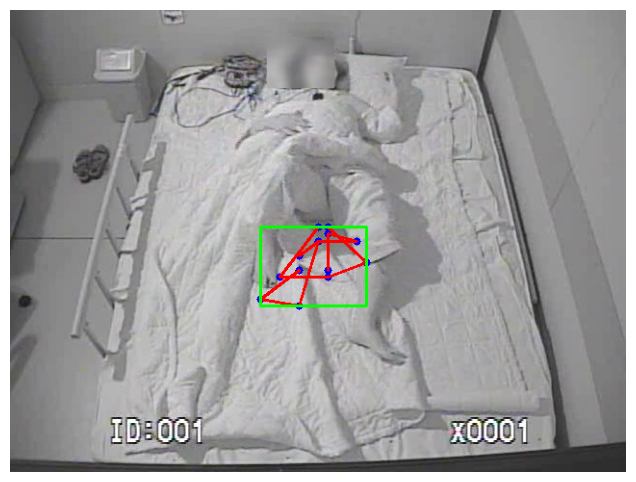

In [13]:
# 6) 스켈레톤과 바운딩 박스 시각화
os.makedirs(OUTPUT_DIR, exist_ok=True)
result_path = os.path.join(OUTPUT_DIR, "pose_skeleton_result.jpg")
visualize_pose_skeleton_on_original(IMAGE_PATH, pred, bbox, (64, 64), save_path=result_path)